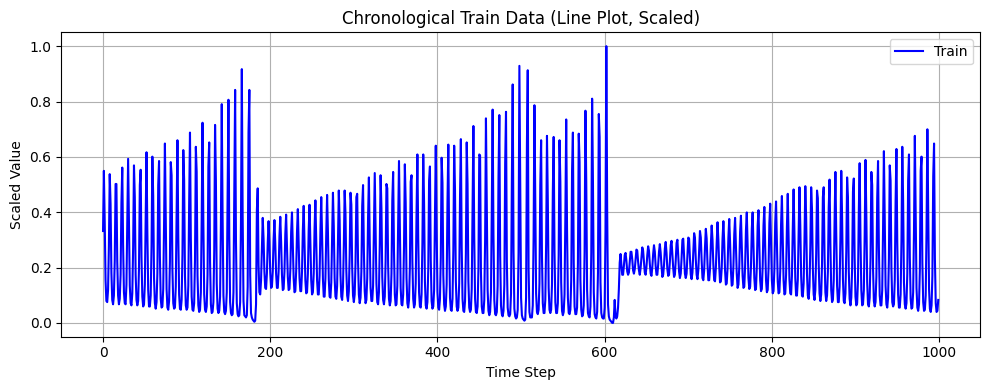

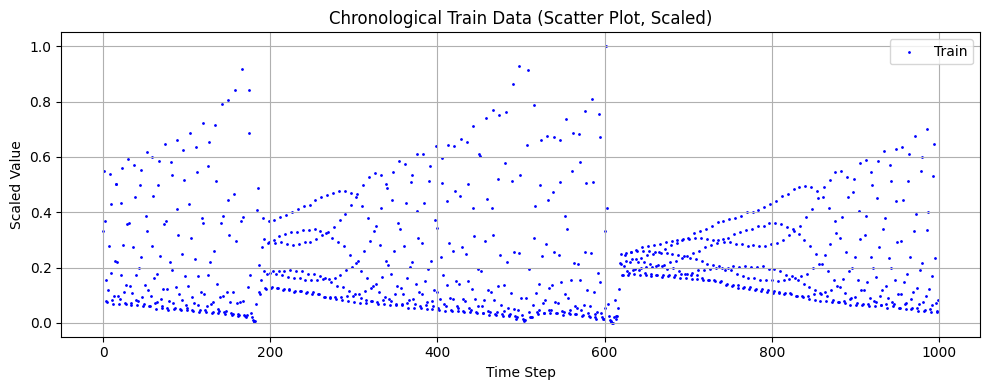

In [1]:
import torch
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

#Load the datafile
data = loadmat('Xtrain.mat')
data = data['Xtrain'].squeeze()
data = data.reshape(-1, 1)



#Scale data between [0,1] use min and max from train data and apply those to val data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#Line plot dataset
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(data_scaled)), data_scaled, label='Train', color='blue')
plt.title("Chronological Train Data (Line Plot, Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Scatter plot dataset
plt.figure(figsize=(10, 4))
plt.scatter(np.arange(len(data_scaled)), data_scaled, s=1, label='Train', color='blue')
plt.title("Chronological Train Data (Scatter Plot, Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
#For the whole lader sequence generate corresponding data points. X is the first input_len of numbers, Y is the one after. 
#Loop over the whole laser sequence
def create_sequences(data, input_len):    
    X, Y = [], []
    for i in range(len(data) - input_len):
        X.append(data[i:i + input_len])
        Y.append(data[i + input_len])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    return X, Y


In [3]:
import torch.nn as nn

#Define LSTM model
class LSTMOneStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.0):
        super(LSTMOneStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM stack
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  
        )

        #Model ehead
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)        
        out = lstm_out[:, -1, :]           
        out = self.head(out)               
        return out

#Define DeepLSTM model
class DeepLSTMOneStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.0):
        super(DeepLSTMOneStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM stack
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  
        )

        #Model ehead
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)        
        out = lstm_out[:, -1, :]           
        out = self.head(out)              
        return out   


In [4]:
# Fixed version of train_model that generates sequences inside based on input_len
import torch.optim as optim
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model(ModelClass, data_scaled, input_len=50, hidden_size=248, num_layers=3, dropout=0.4,
                learning_rate=0.0005, batch_size=32, epochs=100, patience=5, n_splits=5):

    # Generate sequences based on input_len
    X_all, Y_all = create_sequences(data_scaled, input_len)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores, mse_scores = [], []    

    fold = 1
    for train_index, val_index in tscv.split(X_all):
        print(f"\n{ModelClass.__name__} - Fold {fold}")

        X_train, X_val = X_all[train_index], X_all[val_index]
        Y_train, Y_val = Y_all[train_index], Y_all[val_index]

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

        model = ModelClass(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for xb, yb in train_loader:
                pred = model(xb)
                loss = loss_fn(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    pred = model(xb)
                    val_loss = loss_fn(pred, yb)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)

            #print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        model.eval()
        input_seq = X_val[0].unsqueeze(0)
        preds = []
        with torch.no_grad():
            for _ in range(len(Y_val)):
                pred = model(input_seq)
                preds.append(pred.item())
                new_input = torch.cat([input_seq[:, 1:, :], pred.unsqueeze(0)], dim=1)
                input_seq = new_input

        val_preds = np.array(preds)
        val_targets = Y_val.squeeze().numpy()

        mae = mean_absolute_error(val_targets, val_preds)
        mse = mean_squared_error(val_targets, val_preds)
        mae_scores.append(mae)
        mse_scores.append(mse)

        print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}")

        fold += 1

    print(f"\n{ModelClass.__name__} - Average MAE: {np.mean(mae_scores):.4f}, Average MSE: {np.mean(mse_scores):.4f}")
    return mae_scores, mse_scores



In [ ]:

input_lens = [50, 100, 200]
results = {}

for input_len in input_lens:    
    mae_scores, mse_scores = train_model(LSTMOneStep, data_scaled=data_scaled, input_len=input_len)
    results[len] = {
        "avg_mae": np.mean(mae_scores),
        "avg_mse": np.mean(mse_scores),
        "mae_scores": mae_scores,
        "mse_scores": mse_scores
    }

#Select best input_len based on average MAE
best_len = min(results, key=lambda l: results[l]["avg_mae"])

print(f"\nBest input_len based on average MAE: {best_len}")
print(f"MAE: {results[best_len]['avg_mae']:.4f}, MSE: {results[best_len]['avg_mse']:.4f}")


C:\Users\brien\AppData\Local\Temp\ipykernel_1388\199105474.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X = torch.tensor(X, dtype=torch.float32)



LSTMOneStep - Fold 1
Epoch 1: Train Loss = 0.1016, Val Loss = 0.0433
Epoch 2: Train Loss = 0.0599, Val Loss = 0.0256
Epoch 3: Train Loss = 0.0497, Val Loss = 0.0210
Epoch 4: Train Loss = 0.0503, Val Loss = 0.0216
Epoch 5: Train Loss = 0.0489, Val Loss = 0.0206
Epoch 6: Train Loss = 0.0482, Val Loss = 0.0210
Epoch 7: Train Loss = 0.0471, Val Loss = 0.0205
Epoch 8: Train Loss = 0.0478, Val Loss = 0.0206
Epoch 9: Train Loss = 0.0495, Val Loss = 0.0204
Epoch 10: Train Loss = 0.0478, Val Loss = 0.0204
Epoch 11: Train Loss = 0.0486, Val Loss = 0.0204
Epoch 12: Train Loss = 0.0480, Val Loss = 0.0204
Epoch 13: Train Loss = 0.0477, Val Loss = 0.0203
Epoch 14: Train Loss = 0.0489, Val Loss = 0.0202
Epoch 15: Train Loss = 0.0481, Val Loss = 0.0202
Epoch 16: Train Loss = 0.0473, Val Loss = 0.0200
Epoch 17: Train Loss = 0.0477, Val Loss = 0.0198
Epoch 18: Train Loss = 0.0473, Val Loss = 0.0196
Epoch 19: Train Loss = 0.0461, Val Loss = 0.0192
Epoch 20: Train Loss = 0.0439, Val Loss = 0.0185
Epoch 2

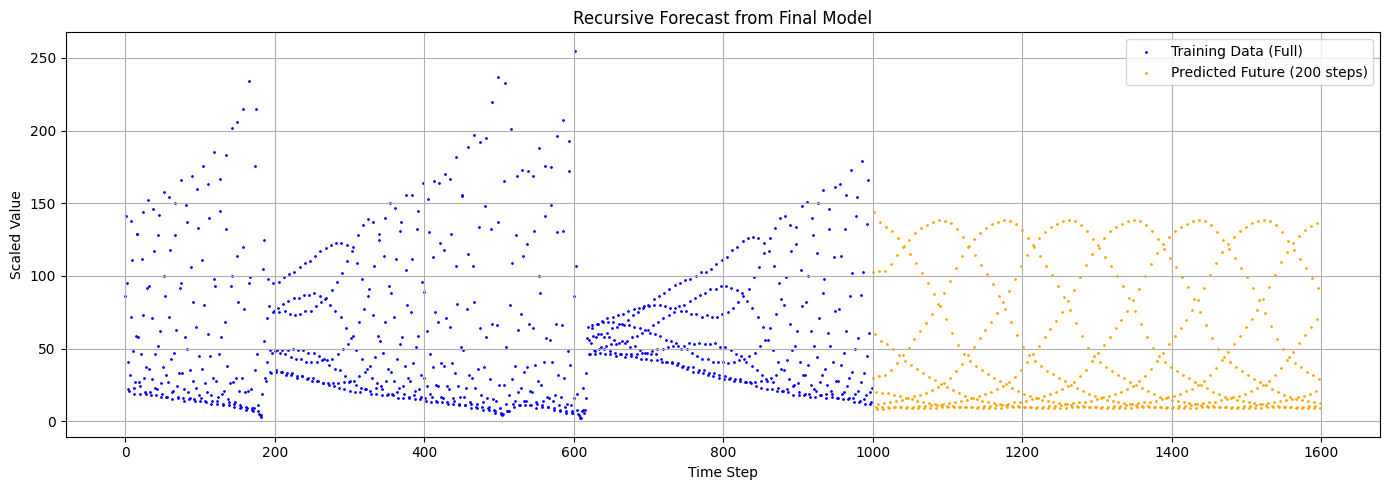

In [66]:
# Final recursive forecast after training (on full data)
model.eval()
prediction_range = 600  # Changed prediction range to 800
predictions_scaled = []

# Start with last input_len values from full train_scaled
last_sequence = torch.tensor(train_scaled[-input_len:], dtype=torch.float32).unsqueeze(0)

# Iterative prediction
with torch.no_grad():
    for _ in range(prediction_range):
        pred = model(last_sequence)
        predictions_scaled.append(pred.item())
        new_val = pred.unsqueeze(2)  # shape: [1, 1, 1]
        last_sequence = torch.cat((last_sequence[:, 1:, :], new_val), dim=1)

# Rescale predictions
predictions_np = np.array(predictions_scaled).reshape(-1, 1)
predictions_unscaled = scaler.inverse_transform(predictions_np).squeeze()

# Plot full training set + 800-step prediction
plt.figure(figsize=(14, 5))
# plt.plot(train_scaled.squeeze(), label="Training Data (Scaled)", color='blue')
# plt.plot(np.arange(len(train_scaled), len(train_scaled) + prediction_range), predictions_scaled, 
#          label="800-Step Forecast (Scaled)", linestyle='--', color='orange')
plt.scatter(np.arange(len(data)), data, label='Training Data (Full)', color='blue', s=1)
plt.scatter(np.arange(len(data), len(data) + len(predictions_unscaled)), predictions_unscaled, 
                label='Predicted Future (200 steps)', color='orange', s=1)
plt.title("Recursive Forecast from Final Model")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
